Conversion reaction
===================

In [1]:
import importlib
import os
import sys
import numpy as np
import amici
import amici.plotting
import pypesto
import pypesto.optimize as optimize
import pypesto.visualize as visualize

# sbml file we want to import
sbml_file = 'conversion_reaction/model_conversion_reaction.xml'
# name of the model that will also be the name of the python module
model_name = 'model_conversion_reaction'
# directory to which the generated model code is written
model_output_dir = 'tmp/' + model_name

## Compile AMICI model

In [2]:
# import sbml model, compile and generate amici module
sbml_importer = amici.SbmlImporter(sbml_file)
sbml_importer.sbml2amici(model_name,
                         model_output_dir,
                         verbose=False)

## Load AMICI model

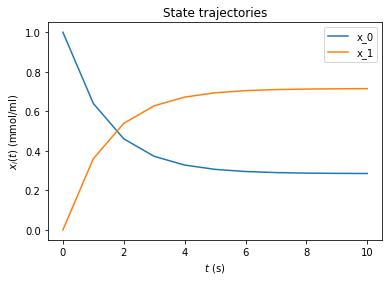

In [3]:
# load amici module (the usual starting point later for the analysis)
sys.path.insert(0, os.path.abspath(model_output_dir))
model_module = importlib.import_module(model_name)
model = model_module.getModel()
model.requireSensitivitiesForAllParameters()
model.setTimepoints(np.linspace(0, 10, 11))
model.setParameterScale(amici.ParameterScaling.log10)
model.setParameters([-0.3,-0.7])
solver = model.getSolver()
solver.setSensitivityMethod(amici.SensitivityMethod.forward)
solver.setSensitivityOrder(amici.SensitivityOrder.first)

# how to run amici now:
rdata = amici.runAmiciSimulation(model, solver, None)
amici.plotting.plotStateTrajectories(rdata)
edata = amici.ExpData(rdata, 0.2, 0.0)

## Optimize

In [4]:
# create objective function from amici model
# pesto.AmiciObjective is derived from pesto.Objective, 
# the general pesto objective function class
objective = pypesto.AmiciObjective(model, solver, [edata], 1)

# create optimizer object which contains all information for doing the optimization
optimizer = optimize.ScipyOptimizer(method='ls_trf')

# create problem object containing all information on the problem to be solved
problem = pypesto.Problem(objective=objective, 
                          lb=[-2,-2], ub=[2,2])

# do the optimization
result = optimize.minimize(problem=problem, 
                           optimizer=optimizer, 
                           n_starts=10)

## Visualize

<AxesSubplot:xlabel='fval', ylabel='gradient norm'>

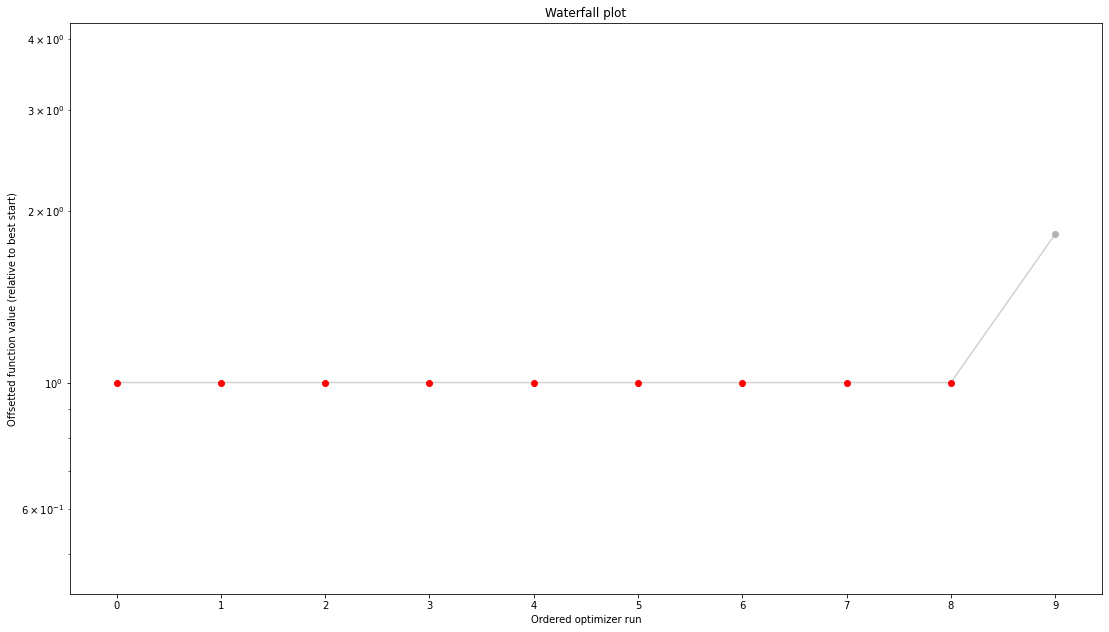

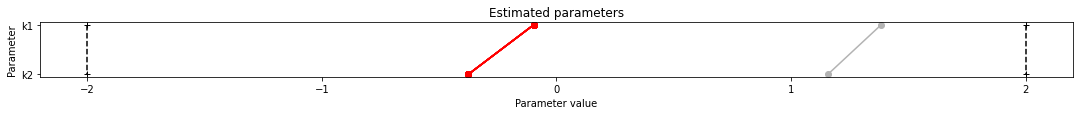

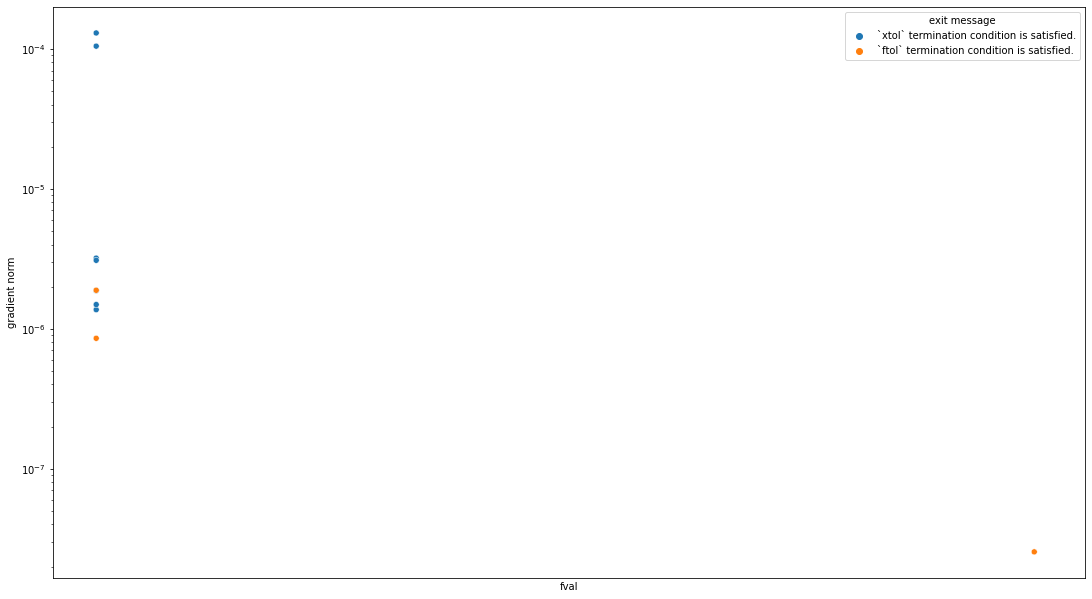

In [5]:
visualize.waterfall(result)
visualize.parameters(result)
visualize.optimizer_convergence(result)

## Profiles

In [6]:
import pypesto.profile as profile

profile_options = profile.ProfileOptions(min_step_size=0.0005,
    delta_ratio_max=0.05,
    default_step_size=0.005,
    ratio_min=0.01)

result = profile.parameter_profile(
    problem=problem,
    result=result,
    optimizer=optimizer,
    profile_index=np.array([1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]),
    result_index=0,
    profile_options=profile_options)

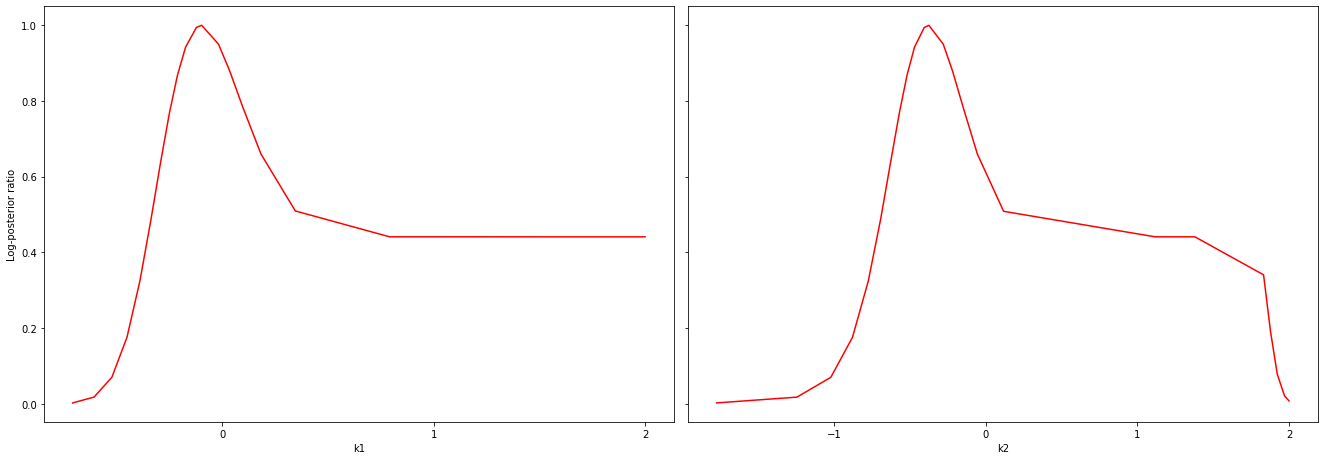

In [7]:
# specify the parameters, for which profiles should be computed
ax = visualize.profiles(result)

## Sampling

In [8]:
import pypesto.sample as sample

sampler = sample.AdaptiveParallelTemperingSampler(
    internal_sampler=sample.AdaptiveMetropolisSampler(),
    n_chains=3)

result = sample.sample(problem, n_samples=10000, sampler=sampler, result=result)

100%|██████████| 10000/10000 [00:57<00:00, 173.48it/s]


Burn in index not found in the results, the full chain will be shown.
You may want to use, e.g., 'pypesto.sample.geweke_test'.


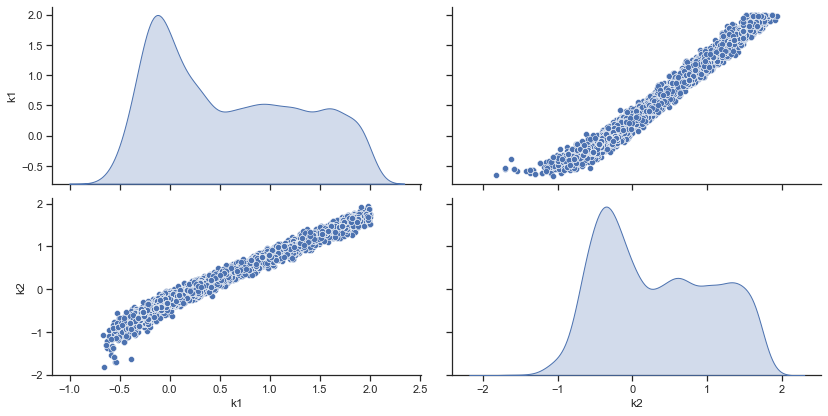

In [9]:
ax = visualize.sampling_scatter(result, size=[13,6])